In [1]:
import random
from argparse import ArgumentParser
from decimal import Decimal
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pandas as pd
import numpy as np
from preprocess_data import clean_data, create_balance_df, parse_and_assign_cex
from analyze_data import *
import os.path

Load data files

In [2]:
file_balances = "../data/uniswap.csv"
file_original = "../data/outputUniswap_fromBlock_10861674_toBlock_19955500.csv"
timelock_address = "0x1a9c8182c09f50c8318d769245bea52c32be35bc"

Initialize data frames

In [3]:
df_uniswap = pd.read_csv(file_balances)
df_uniswap["balance"] = df_uniswap["balance"].apply(Decimal)
df_uniswap["amount_in"] = df_uniswap["amount_in"].apply(Decimal)
df_uniswap["amount_out"] = df_uniswap["amount_out"].apply(Decimal)

/tmp/ipykernel_15182/906224226.py:1: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_uniswap = pd.read_csv(file_balances)


Preprocess data

In [4]:
# remove negative balances and sort descending
non_negative_df = clean_data(df_uniswap)

# remove zero balances
only_positive_df = remove_zero_balances(non_negative_df)
only_positive_df_removed_timelockAddress = remove_address(only_positive_df, timelock_address)

print("Number of addresses that hold tokens: \n", only_positive_df_removed_timelockAddress.shape[0])

Number of addresses that hold tokens: 
 382522


## Metrics

In [5]:
only_positive_df_removed_timelockAddress.head(10)

,Unnamed: 0,address,amount_in,amount_out,balance,cex
370039,370039,0x47173b170c64d16393a52e6c480b3ad8c302ba1e,39761682693918000000000000,16714202180719478000000000,23047480513198522000000000,NaN
318385,318385,0x3d30b1ab88d487b0f3061f40de76845bec3f1e94,43000000000000000000000000,26223928240740740740740738,16776071759259259259259262,NaN
649014,649014,0x7d2d43e63666f45b40316b44212325625dbaeb40,15759557158154400000000000,2504870339500000000000000,13254686818654400000000000,NaN
48214,48214,0x090d4613473dee047c3f2706764f49e0821d256e,150002600459653843000000000,136965580688674000000000000,13037019770979843000000000,NaN
78010,78010,0x0ec9e8aa56e0425b60dee347c8efbad959579d0f,30000000076569300000000000,17388668720908390000000000,12611331355660910000000000,NaN
1290796,1290796,0xf977814e90da44bfa03b6295a0616a897441acec,81716912931976964981621181,69208316922976964981621181,12508596009000000000000000,binance
564338,564338,0x6cc5f688a315f3dc28a7781717a9a798a59fda7b,100354081826020357678147603,88846188151855080000000000,11507893674165277678147603,okex
469356,469356,0x5a52e96bacdabb82fd05763e25335261b270efcb,26666973000000000000000000,15866973000000000000000000,10800000000000000000000000,binance
702543,702543,0x878f0822a9e77c1dd7883e543747147be8d63c3b,24700000000000000000000000,13936624086003920000000000,10763375913996080000000000,NaN
853382,853382,0xa4c9492d5f1578911756a4f8463b45482deae37a,21880414703401288796733440,12570489829000000000000000,9309924874401289000000000,NaN


In [6]:
# some statistics

print_top_percentages(only_positive_df_removed_timelockAddress)
print_top_traders(only_positive_df_removed_timelockAddress)
print_tokens_per_block(file_original)
print_cex_percentages(only_positive_df_removed_timelockAddress)


Top 10 percentage: 21.70%
Top 100 percentage: 73.94%
Top 1000 percentage: 95.61%
Top senders:                                             address  \
340204   0x41653c7d61609d856f29355e404f310ec4142cfb   
153078   0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801   
1095711  0xd3d2e2692501a5c9ca623199d38826e513033a17   
745201   0x8fdb3816fe10e16aaa9b12b3c4688c873efe2eca   
447613   0x56178a0d5f301baf6cf3e1cd53d9863437345bf9   
212842   0x28c6c06298d514db089934071355e5743bf21d60   
879423   0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43   
279335   0x35a18000230da775cac24873d00ff85bccded550   
48214    0x090d4613473dee047c3f2706764f49e0821d256e   
948567   0xb739d0895772dbb71a89a3754a160269068f0d45   

                             balance          cex  
340204              2758162612694493          NaN  
153078   2389244318714231259971746.0          NaN  
1095711   296150534151073172965800.0          NaN  
745201                  224000000000          NaN  
447613                          2287    

### Gini index

In [7]:
gini_index = compute_gini_index(only_positive_df_removed_timelockAddress)
print("gini index: ", gini_index)

gini index:  0.9952059161147626132523910141


### Herfindahl hirschman index:

In [8]:
hhi = compute_herfindahl_hirschman_index(only_positive_df_removed_timelockAddress)
print("hhi: ", hhi)

# limited to the top 50 token holder
hhi = compute_herfindahl_hirschman_index(only_positive_df_removed_timelockAddress, top_n_player=50)
print("hhi: ", hhi)

hhi:  0.009764410451879473895116381213
hhi:  0.009056389611931172638580423389


## Charts

### Timeline
Gini index in timeline:

In [21]:
block_step_size = 100_000
gini_timeline_file = "../data/gini_timeline_step_size_" + str(block_step_size) + ".csv"

if os.path.isfile(gini_timeline_file):
    # file already exists
    gini_indices = pd.read_csv(gini_timeline_file)
    
else:
    gini_indices = create_and_export_gini_timeline(file_original, block_step_size, gini_timeline_file)

gini_indices

,block_number,gini_index
0,10961674,0.989849
1,11061674,0.991963
2,11161674,0.993115
3,11261674,0.993525
4,11361674,0.994157
...,...,...
85,19461674,0.995198
86,19561674,0.995217
87,19661674,0.995226
88,19761674,0.995180


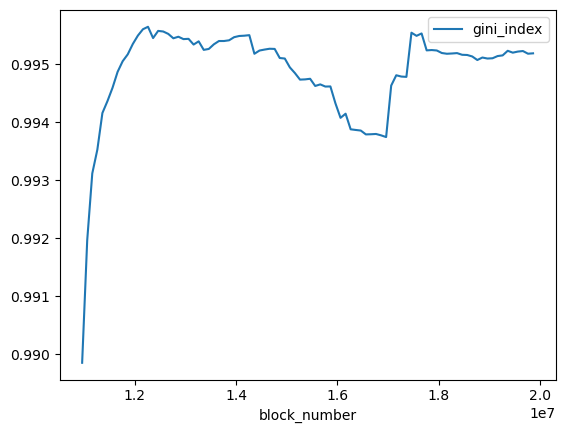

In [22]:
gini_indices['gini_index'] = gini_indices["gini_index"].apply(float)
create_timeline_plot(gini_indices)

In [11]:
# TODO: Create timeline for HH Index
# TODO: Show tx frequency for all transfers (+ maybe: for top traders or cex's)

### Pie Chart
Balances distribution pie chart:

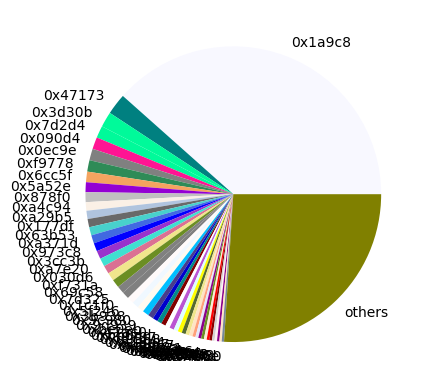

In [12]:
# all addresses with positive balance
create_pie_chart(
    merge_others_at_cut_off_value(only_positive_df, 50), 
    "../data/uniswap_pie_chart.png")

The timelock address holds a huge amount of the tokens.

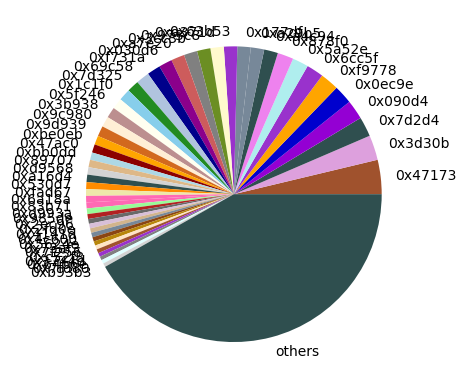

In [13]:
# all addresses with positive balance, except the timelock address
create_pie_chart(
    merge_others_at_cut_off_value(only_positive_df_removed_timelockAddress, 50), 
    "../data/uniswap_pie_chart.png")

In [14]:
a = "0x0000000000000000000000003d30b1ab88d487b0f3061f40de76845bec3f1e94"
a = "0x" + a[-40:]
print(a)

0x3d30b1ab88d487b0f3061f40de76845bec3f1e94


In [16]:
df_cex_not_None = only_positive_df_removed_timelockAddress[~pd.isnull(only_positive_df_removed_timelockAddress["cex"])]
df_cex_is_None = only_positive_df_removed_timelockAddress[pd.isnull(only_positive_df_removed_timelockAddress["cex"])]

print("Number of cex addresses: ", df_cex_not_None.shape[0])
print("Number of other addresses: ", df_cex_is_None.shape[0])

Number of cex addresses:  45
Number of other addresses:  382477


         cex                     balance
2    binance  36697432554638172652161204
19      okex  11521347873058447678147604
15    kraken   2111022000000000000000000
6      bybit   2001647090445974192469061
0   Bitfinex    679845080220188696398220


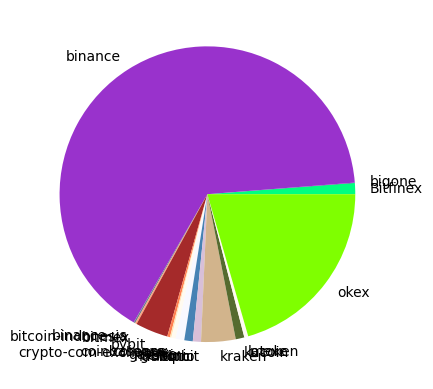

In [25]:
df_cex = aggregate_cex_balances(only_positive_df_removed_timelockAddress)
print(df_cex.sort_values("balance", ascending=False).head(5))

create_pie_chart(df_cex, '../data/uniswap_pie_chart_cex.png', labels=df_cex['cex'])